In [1]:
import PIL
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstatsπ
from tqdm.notebook import tqdm

from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
from scipy import stats, interpolate
from astropy.visualization import hist
from astroML.density_estimation import EmpiricalDistribution

# Position of a quasar

We want to simulate some telescope data of a quasar position and estimate the true position out of the one we have

## Part 1

If the data are taken the same night, the measurment are independent but the uncertainties $\sigma_i$ are homoscedastic (i.e. they are all the same)\
$\rightarrow$ Homoscedasctic Gaussian $G(\mu,\sigma$)!

We know that the sample mean $\mu$ is:
$$ \bar{x} = \frac{\sum_{i=1}^N{x_i}}{N} $$

and the uncertainty on the mean $\sigma_{\mu}$ is:
$$ \sigma_{x} = \frac{ \sigma}{\sqrt{N}} $$

We want to use the Maximum Likelihood estimator because is consistent with the data, is asymptotically normal and achieves the minimum possible variance, moreover for gaussian maximizing the (log)likelihood is equal to minimizing the $\chi^2$.\
The likelihood is the product of all the probabilities, so if we have guassians:

$$L = \prod_{i=1}^N{G(\mu,\sigma|x_i)} \propto exp\bigg(\frac{-\chi^2}{2}\bigg)$$

Things are easier if we consider the $log(L)$ because we are dealing with exponentials, and since the log is monotone 

$$\Longrightarrow \text{x | max(L) = x | max(log(L))}$$

We want to estimate the $\hat{\theta}=[\mu, \sigma_{\mu}]$ given our data, that are the mean of the distribution and its variance. The mean can be found maximizing the loglikelihood:

$$ \frac{d(log(L)}{d\theta}\bigg|_{\hat{\theta} = \mu} = 0$$

In [2]:
N = 20
n = 1000
mu = 1.0
sigma = 0.2

Check the underlying distribution, then let's pretend we don't know it!

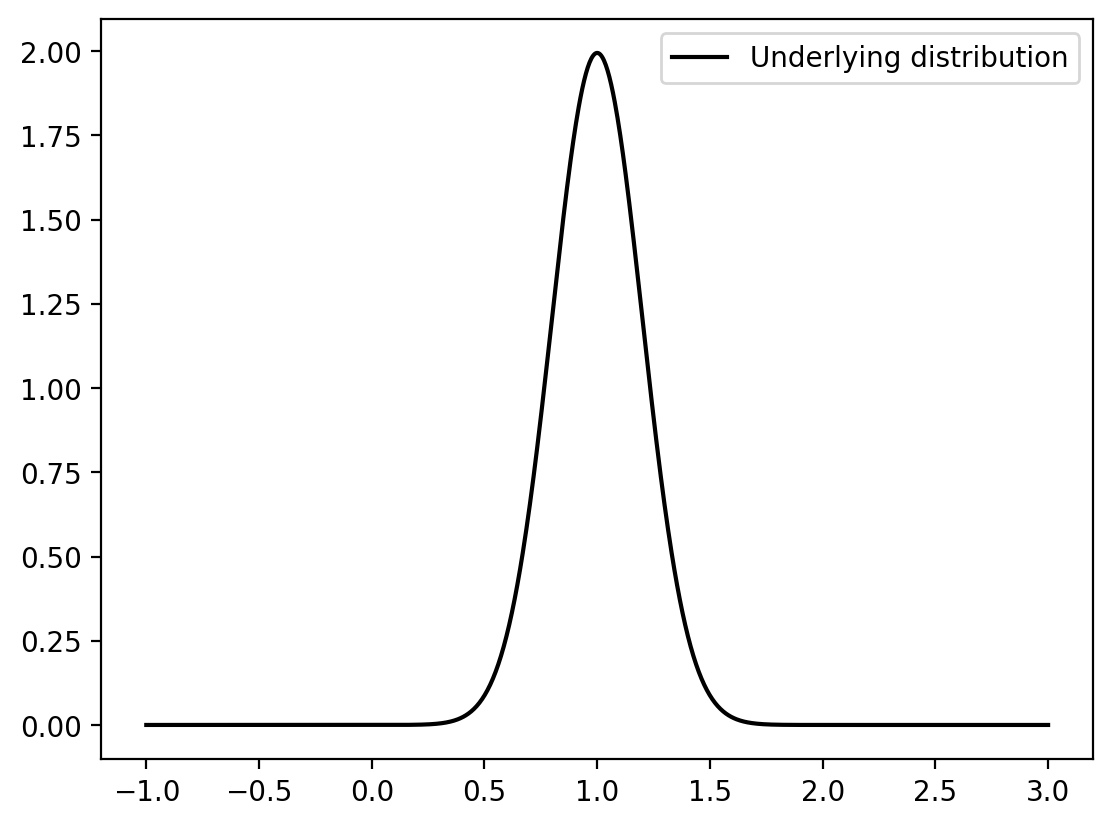

In [3]:
#x_gaus = np.random.uniform(-1,3,n)
x_gaus = np.linspace(-1,3,n)

# y-axis as the gaussian
y_gaus = stats.norm.pdf(x_gaus, mu, sigma)
  
## plot function
plt.plot(x_gaus, y_gaus, 'black', zorder=0, label="Underlying distribution")
plt.legend()
plt.show()

Now I want to generate some fake data such as they are normally distributed around $\mu$ with given $\sigma$
 $\rightarrow$ they'll be our "measurement" of a quasar position affected by a gaussian uncertainties

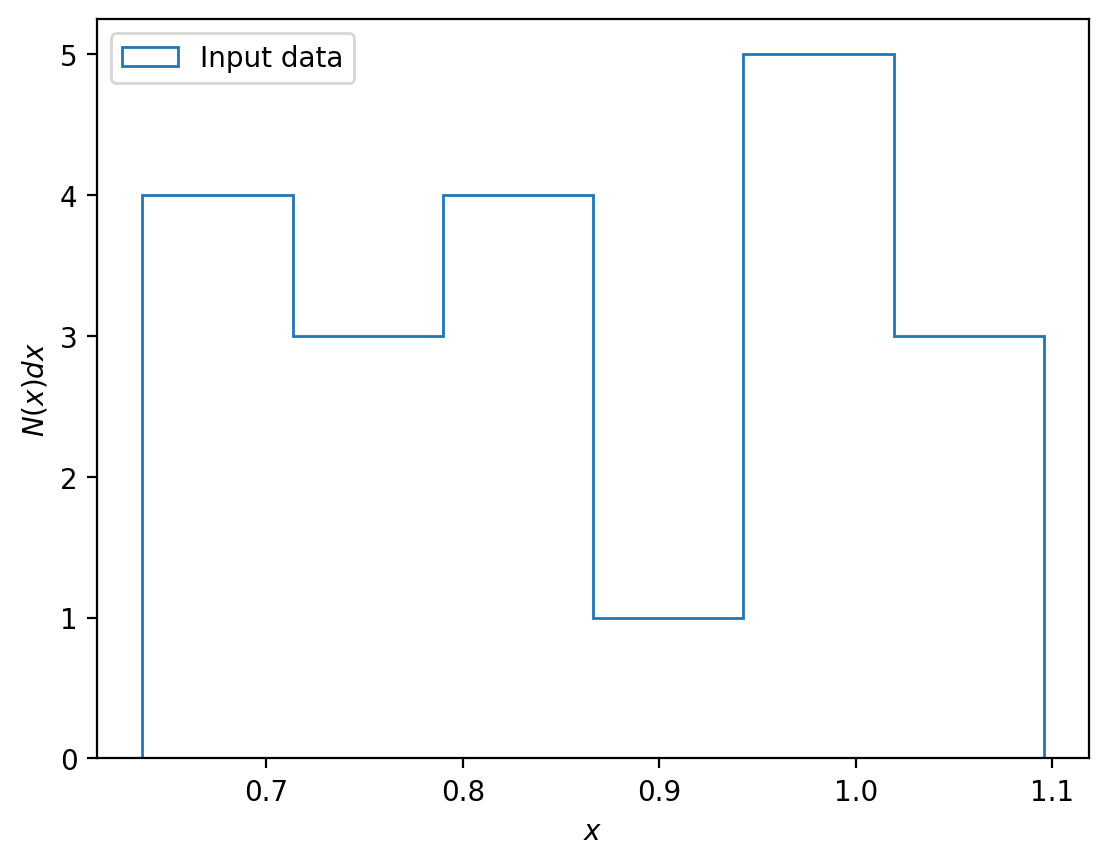

In [4]:
#generate some x data normally distributed around mu with sigma
x_norm = np.random.normal(mu, sigma, N)

#check that they do are normally distributed arround mu with sigma 
plt.hist(x_norm, bins=6, histtype='step', label="Input data")
plt.xlabel('$x$')
plt.ylabel('$N(x)dx$')
plt.legend()
plt.show()

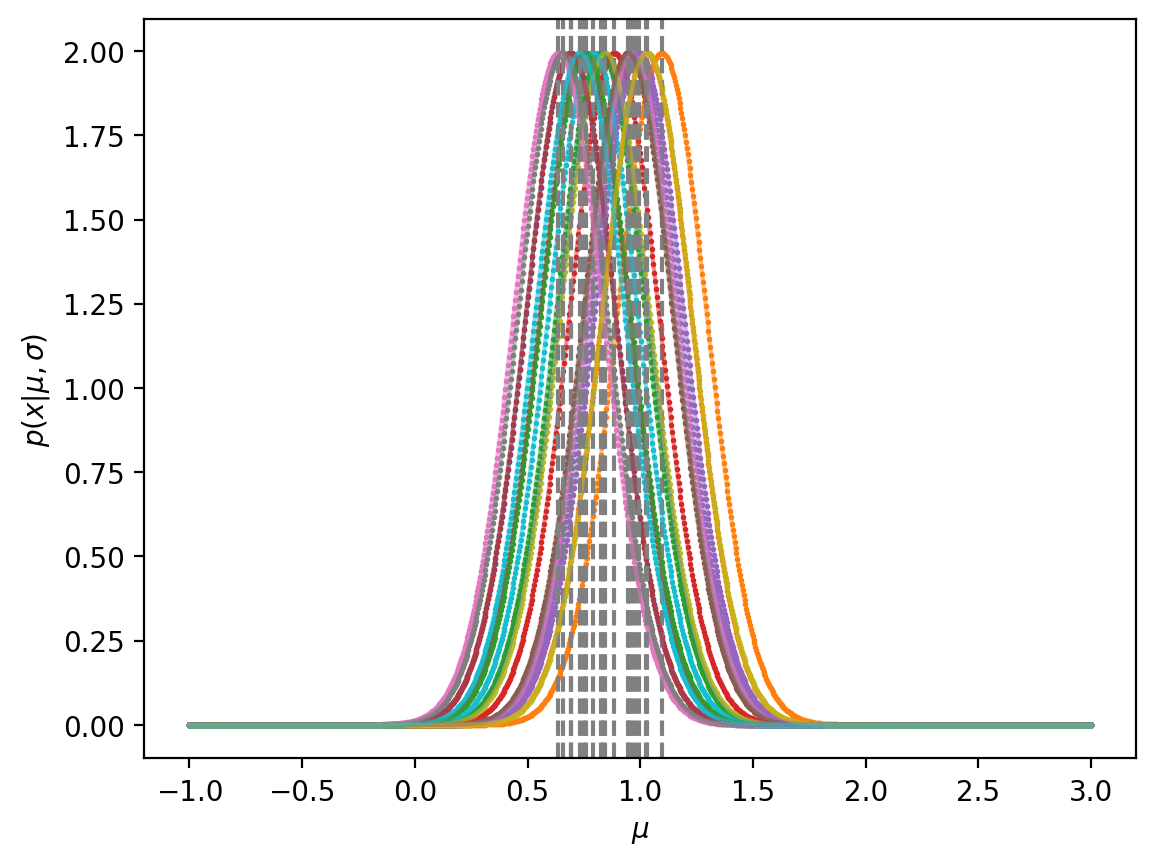

In [5]:
x_data = np.zeros((N,n))
y_data = np.zeros((N,n))
y_tot = []
#print(y_tot)

for i in range(0,N):
    y_i = stats.norm.pdf(x_gaus, x_norm[i], sigma)
    y_data[i,:] = y_i
    plt.scatter(x_gaus, y_data[i,:], s=1)
    plt.plot(x_gaus, y_data[i,:], alpha=0.5)
    plt.axvline(x = x_norm[i], color='gray', ls='dashed')
plt.xlabel('$\mu$')
plt.ylabel('$p(x|\mu,\sigma)$')
plt.show()

y_tot = np.array([np.prod(y_data[:,i]) for i in np.arange(0,n)])
MLE = np.argmax(y_tot)
#print("MLE",x_gaus[MLE])

In [6]:
y_sum_log = [np.sum(np.log(y_data[:,i])) for i in np.arange(0,n)]
print(len(y_sum_log),len(y_tot))

1000 1000


We obtained a maximum of the loglikelyhood in x_gaus[MLE]:

In [7]:
mean = np.mean(x_norm)
s_mean = sigma/np.sqrt(N)
mu_loglike = x_gaus[MLE]
print(mean, s_mean, mu_loglike)

0.8539870668418938 0.044721359549995794 0.8538538538538538


/tmp/ipykernel_7532/3625108660.py:33: RuntimeWarning: divide by zero encountered in log
  ax.plot(x_gaus, np.log(y_tot),'k', label='Log(prod)')
/tmp/ipykernel_7532/3625108660.py:50: RuntimeWarning: divide by zero encountered in log
  ax.plot(x_gaus, np.log(y_tot),'k')


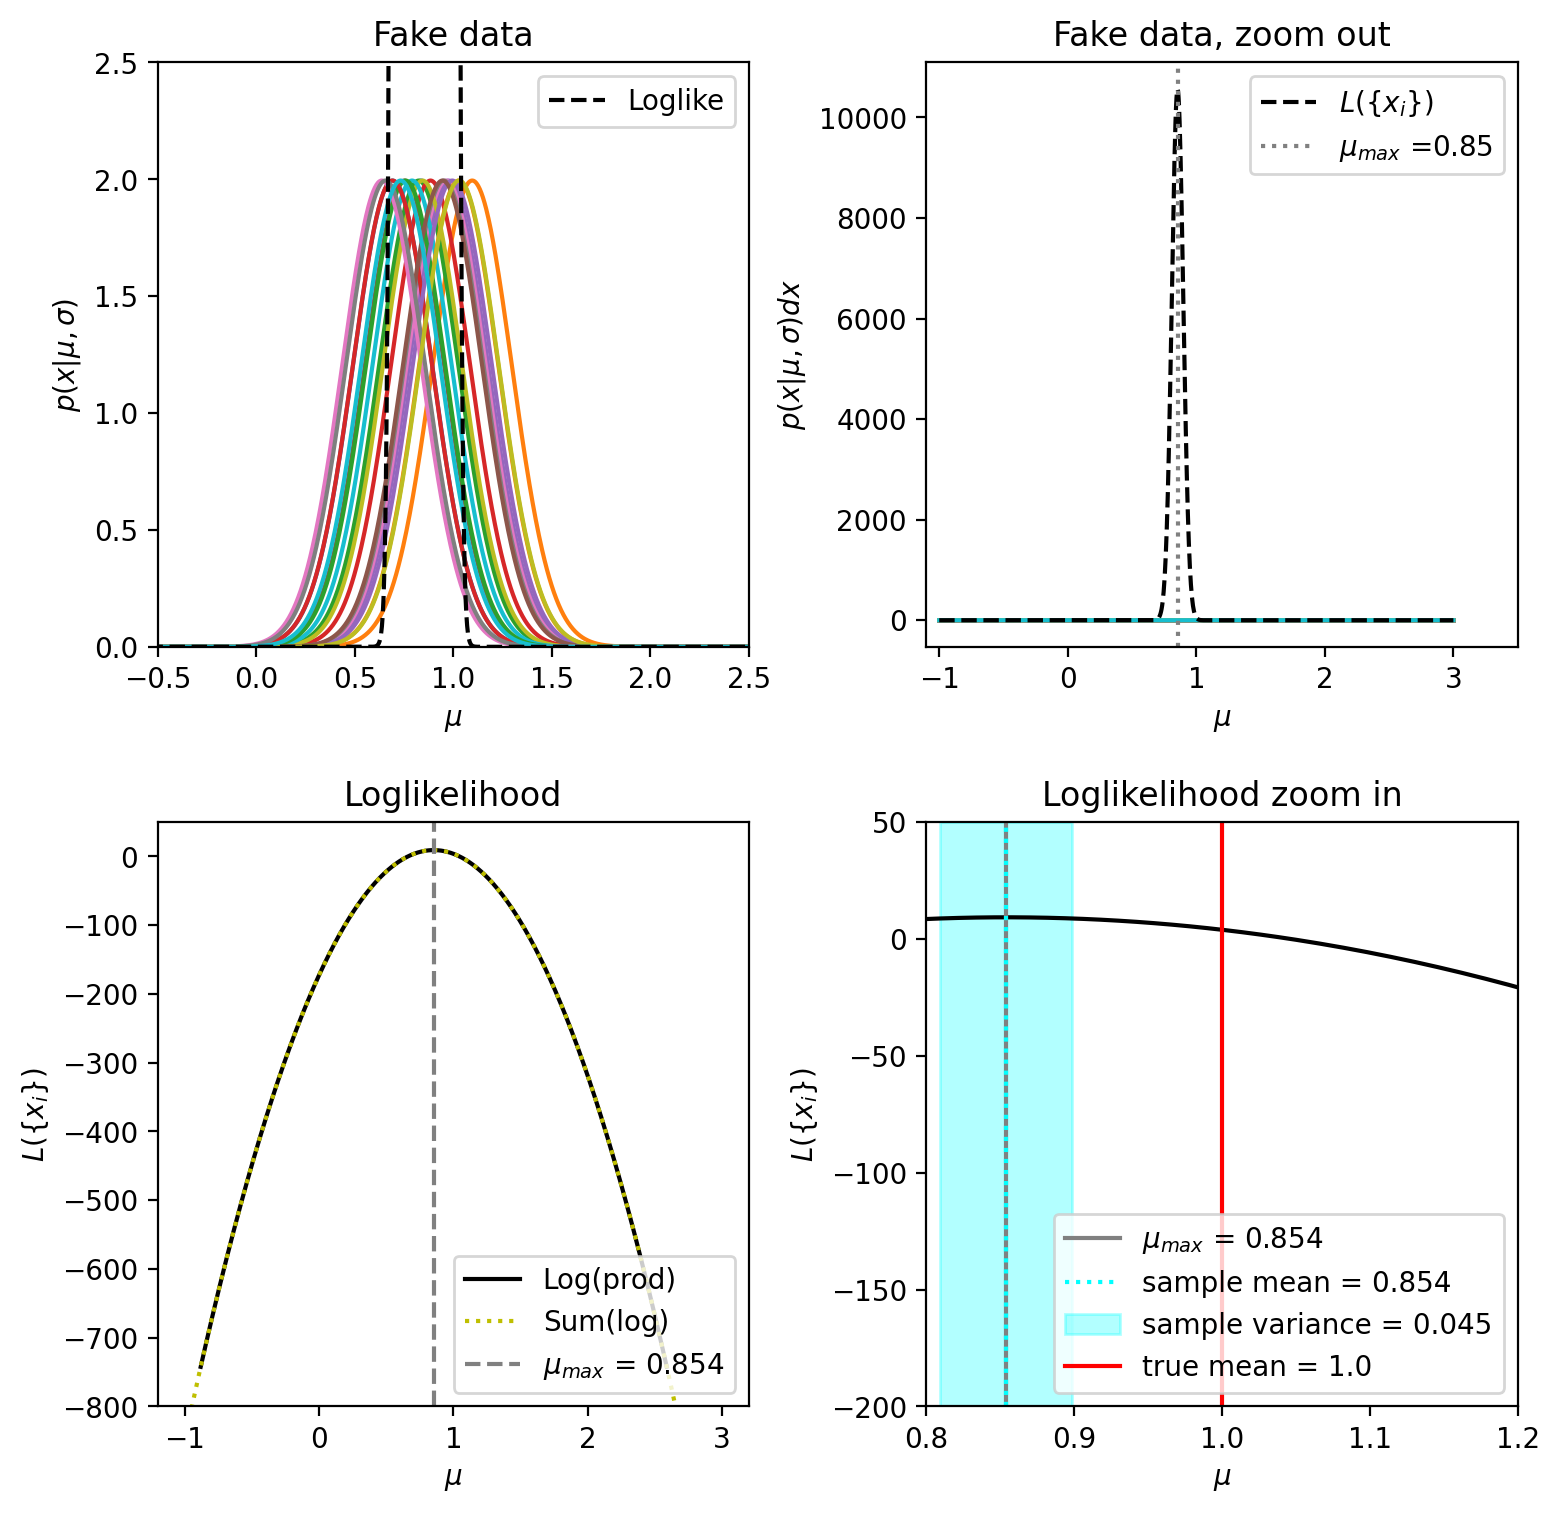

In [8]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=0.3,hspace=0.3, left=0.1, right=0.95,bottom=0.08, top=0.92)

# plot
ax = fig.add_subplot(221)

for i in np.arange(0,N):
    ax.plot(x_gaus, y_data[i,:])
ax.plot(x_gaus, y_tot,'--k', label='Loglike')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$p(x|\mu,\sigma)$')
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(0,2.5)
ax.set_title('Fake data')
plt.legend()

ax = fig.add_subplot(222)

for i in np.arange(0,N):
    ax.plot(x_gaus, y_data[i,:])
ax.plot(x_gaus, y_tot,'--k', label='$L(\{x_i\})$')
plt.axvline(x = x_gaus[MLE], c='gray', ls='dotted', label='$\mu_{max}$ =' f'{round(x_gaus[MLE],2)}')
#plt.text(x_gaus[MLE]+0.2, 5, x_gaus[MLE],rotation=90)
ax.set_xlabel('$\mu$')
ax.set_ylabel('$p(x|\mu,\sigma)dx$')
ax.set_title('Fake data, zoom out')
ax.set_xlim(-1.1,3.5)
plt.legend(loc='upper right')

ax = fig.add_subplot(223)

#check that log(prod) and sum(log) are the same
ax.plot(x_gaus, np.log(y_tot),'k', label='Log(prod)')
ax.plot(x_gaus, y_sum_log,'y:', label='Sum(log)')
plt.axvline(x = x_gaus[MLE], c='gray', ls='dashed', label='$\mu_{max}$ = ' f'{round(x_gaus[MLE],3)}')
#plt.text(x_gaus[MLE]+0.2, 5, x_gaus[MLE],rotation=90)
#plt.axvline(x = mean, c='cyan', ls='dotted', label='sample mean = ' f'{round(mean,3)}')
#plt.axvline(x = mu, c='red', ls='dashed', label='true mean = ' f'{round(mu,1)}')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$L(\{x_i\})$')
ax.set_title('Loglikelihood')
ax.set_ylim(-800,50)
plt.legend(loc='lower right')

ax = fig.add_subplot(224)

x1 = mean - s_mean
x2 = mean + s_mean

ax.plot(x_gaus, np.log(y_tot),'k')
plt.axvline(x = x_gaus[MLE], c='gray', label='$\mu_{max}$ = ' f'{round(x_gaus[MLE],3)}')
#plt.text(x_gaus[MLE]+0.2, 5, x_gaus[MLE],rotation=90)

plt.axvline(x = mean, c='cyan', ls='dotted', label='sample mean = ' f'{round(mean,3)}')
ax.axvspan(x1, x2, alpha=0.3, color='cyan', label='sample variance = 'f'{round(s_mean,3)}')

plt.axvline(x = mu, c='red', label='true mean = ' f'{round(mu,1)}')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$L(\{x_i\})$')
ax.set_title('Loglikelihood zoom in')
ax.set_xlim(mu - sigma,mu + sigma)
ax.set_ylim(-200,50)
plt.legend(loc='lower right')

plt.show()

## Part 2

We know that for the uncertainties on the estimator of the mean $\hat{\theta} = \mu$ we have to consider the $\sigma_{jk}$ covariance matrix.\
Analitically, if guassian is homoscedastic:

$$ \sigma_{\mu} = \sigma_{ii} = \sqrt{F_{ii}^{-1}} $$

Where $F_{jk}$ is the Fisher matrix and the indep uncertainties lay on its diagonal, that can be found as:

$$ F_{ii} =  \frac{d^2(log(L)}{d\theta^2}\bigg|_{\hat{\theta} = \sigma_{\mu}} = 0 $$

Since we do not have the analitical likelihood, I used $\texttt{np.diff}$ to differentiate to the second order the log(L) computed as the sum(log) and to the first order the x.
Then I plotted both the first and second derivative of the log(L) computed as

1) $f'(x) = \frac{\texttt{np.diff}^1(log(L))}{\texttt{np.diff}(x))}$
2) $f"(x) = \frac{\texttt{np.diff}^2(log(L))}{\texttt{np.diff}(x))^2} \rightarrow F_{ii}$

And checked that the second derivative correspond to the slope of the first derivative. This way I found the uncertainty on $\mu \rightarrow \sigma_{\mu}$

In [9]:
#using sum(log) in order not to lose data because of the log

comp_noninf = np.column_stack((x_gaus,y_sum_log))
theta = comp_noninf[:,0]
f_theta = comp_noninf[:,1]
print(comp_noninf.shape, theta.shape)

(1000, 2) (1000,)


In [10]:
diff_ftheta_n1 = np.diff(f_theta, n=1)
diff_theta_n1 = np.diff(theta, n=1)
first_der = np.column_stack((theta[:-1],(diff_ftheta_n1/diff_theta_n1)))
slope = (first_der[10,1] - first_der[first_der.shape[0]-10,1])/(first_der[10,0] - first_der[first_der.shape[0]-10,0])

In [11]:
diff_ftheta_n2 = np.diff(f_theta, n=2)
diff_theta_n2 = np.diff(theta, n=2)

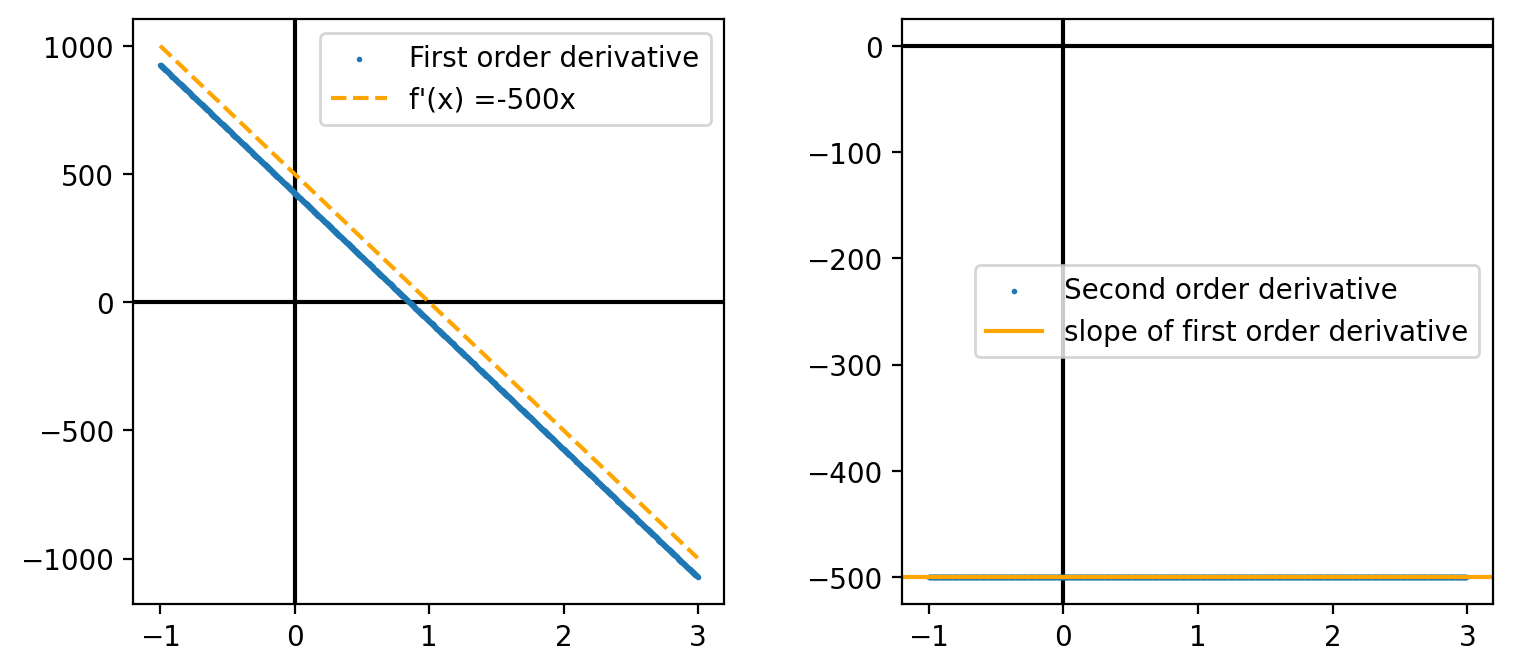

In [12]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=0.3,hspace=0.3, left=0.1, right=0.95,bottom=0.08, top=0.92)

# plot
ax = fig.add_subplot(221)

ax.scatter(theta[:-1], diff_ftheta_n1/diff_theta_n1, s=1, label='First order derivative',zorder=1)
plt.plot(theta[:-1], theta[:-1]*slope+500, color='orange', linestyle='dashed', label="f'(x) ="f"{round(slope)}""x", zorder=2)
ax.axhline(0,color='k', zorder=0)
ax.axvline(0,color='k', zorder=0)
#ax.set_xlabel('$\mu$')
#ax.set_ylabel('$p(x|\mu,\sigma)$')
#ax.set_xlim(-0.5, 2.5)
#ax.set_ylim(0,2.5)
#ax.set_title('Fake data')
ax.legend()

ax = fig.add_subplot(222)

ax.scatter(theta[:-2], diff_ftheta_n2/(diff_theta_n1[:-1])**2, s=1, label='Second order derivative', zorder=1)
ax.axhline(slope,color='orange', label='slope of first order derivative')
ax.axhline(0,color='k', zorder=0)
ax.axvline(0,color='k', zorder=0)
#ax.set_xlabel('$\mu$')
#ax.set_ylabel('$p(x|\mu,\sigma)dx$')
#ax.set_title('Fake data, zoom out')
#ax.set_xlim(-1.1,3.5)
#ax.set_ylim(-2e11,1e11)
ax.legend(loc='center right')

plt.show()

In [13]:
#Fisher matrix uncertainty
mu_uncert = 1/np.sqrt(-slope)
print(mu_uncert, s_mean)

0.04472135954999605 0.044721359549995794


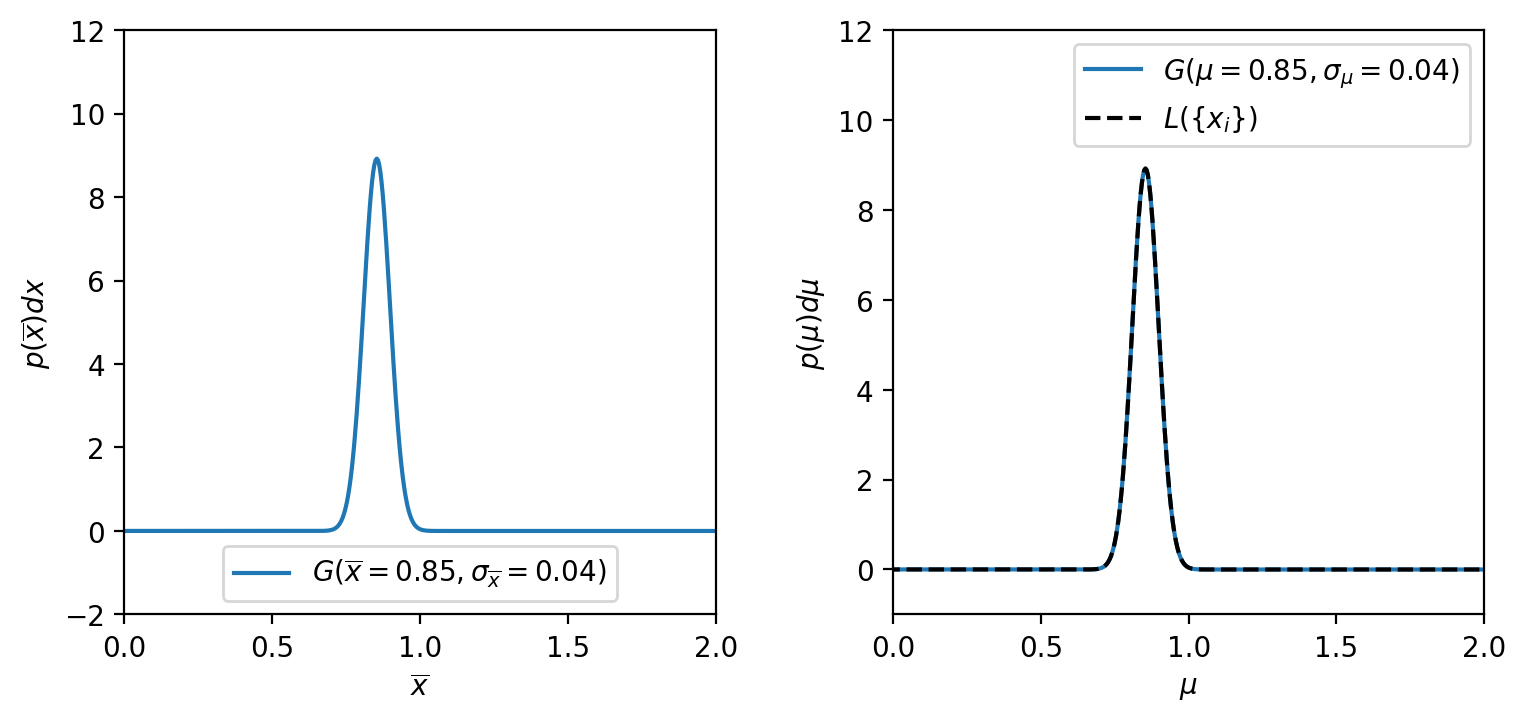

In [14]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=0.3,hspace=0.3, left=0.1, right=0.95,bottom=0.08, top=0.92)

ax = fig.add_subplot(221)

ax.plot(x_gaus, norm.pdf(x_gaus, mean, s_mean), 
        label='$G(\overline{x}='f'{round(mean,2)}'',\sigma_{\overline{x}}='f'{round(s_mean,2)}'')$')
ax.set_xlabel('$\overline{x}$')
ax.set_ylabel('$p(\overline{x})dx$')
ax.legend(loc='lower center')
ax.set_xlim(0,2)
ax.set_ylim(-2,12)


ax = fig.add_subplot(222)
scale = max(y_tot)/max(norm.pdf(x_gaus, mu_loglike, mu_uncert))

ax.plot(x_gaus, norm.pdf(x_gaus, mu_loglike, mu_uncert), 
        label='$G(\mu='f'{round(mu_loglike,2)}'', \sigma_{\mu}='f'{round(mu_uncert,2)}'')$')
ax.plot(x_gaus, y_tot/scale,'--k', label='$L(\{x_i\})$')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$p(\mu)d\mu$')
ax.legend(loc='upper right')
ax.set_xlim(0,2)
ax.set_ylim(-1,12)

plt.show()

In [15]:
print("Differences between means (order of 10 to the):", round(np.log10(np.abs(mu_loglike-mean))), 
      "\nDifferences between sigmas (order of 10 to the):", round(np.log10(np.abs(mu_uncert-s_mean))))

Differences between means (order of 10 to the): -4 
Differences between sigmas (order of 10 to the): -16


## Part 3

If I take the quasar position data in different nights then my uncertainties will be different $\rightarrow$ Heteroscedastic Gaussian $G(\mu, \sigma_i) \Longrightarrow$ also my $\sigma_i$ are distributed as gaussians 
$G(\mu= \sigma_i, \sigma=\sigma_{unc})$

For the sample mean and variance:

$$ \mu = \frac{ \sum_{i=1}^N{(x_i/\sigma_i)^2} }{ \sum_{i=1}^N{(1/\sigma_i)^2} }$$

$$ \sigma{\mu} = \sum_{i=1}^N{\bigg(\frac{1}{\sigma_i^2}\bigg)^{-1/2}} $$

whereas the likelihood estimators are the same as before $\rightarrow$ find them and check that are the same as sample one!

In [16]:
sigma_err = 0.05
N = 10

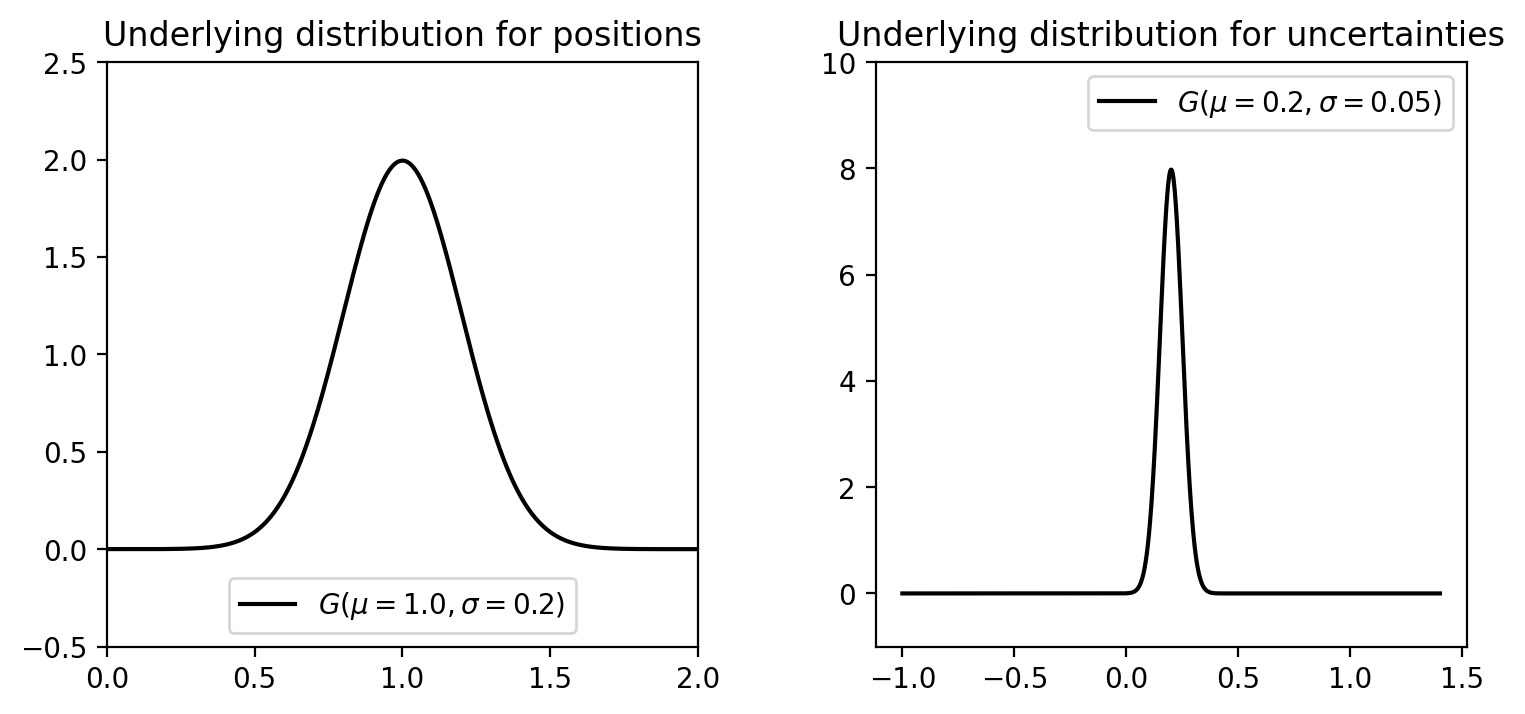

In [17]:
x_gaus_hetero = np.linspace(-1,3,n)
x_gaus_hetero_sigma = np.linspace(-1,1.4,n)

# y-axis as the gaussian
y_gaus_hetero = stats.norm.pdf(x_gaus_hetero, mu, sigma)
y_gaus_hetero_sigma = stats.norm.pdf(x_gaus_hetero_sigma, sigma, sigma_err)
  
## plot function
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=0.3,hspace=0.3, left=0.1, right=0.95,bottom=0.08, top=0.92)

ax = fig.add_subplot(221)

ax.plot(x_gaus_hetero, y_gaus_hetero, 'black', 
        label='$G(\mu='f'{round(mu,2)}'', \sigma ='f'{round(sigma,2)}'')$', zorder=0)
ax.set_title("Underlying distribution for positions")
ax.legend(loc='lower center')
ax.set_xlim(0,2)
ax.set_ylim(-0.5,2.5)


ax = fig.add_subplot(222)
scale = max(y_tot)/max(norm.pdf(x_gaus, mu_loglike, mu_uncert))

ax.plot(x_gaus_hetero_sigma, y_gaus_hetero_sigma, 'black', 
        label='$G(\mu='f'{round(sigma,2)}'', \sigma='f'{round(sigma_err,2)}'')$', zorder=0)
ax.set_title("Underlying distribution for uncertainties")
ax.legend(loc='upper right')
#ax.set_xlim(0,2)
ax.set_ylim(-1,10)

plt.show()

In [18]:
#generate some sigma data normally distributed around sigma with sigma_err
sigma_norm = np.random.normal(sigma, sigma_err, N)

#generate some x data normally distributed around mu with sigma
x_norm_hetero = np.random.normal(mu, sigma, N)

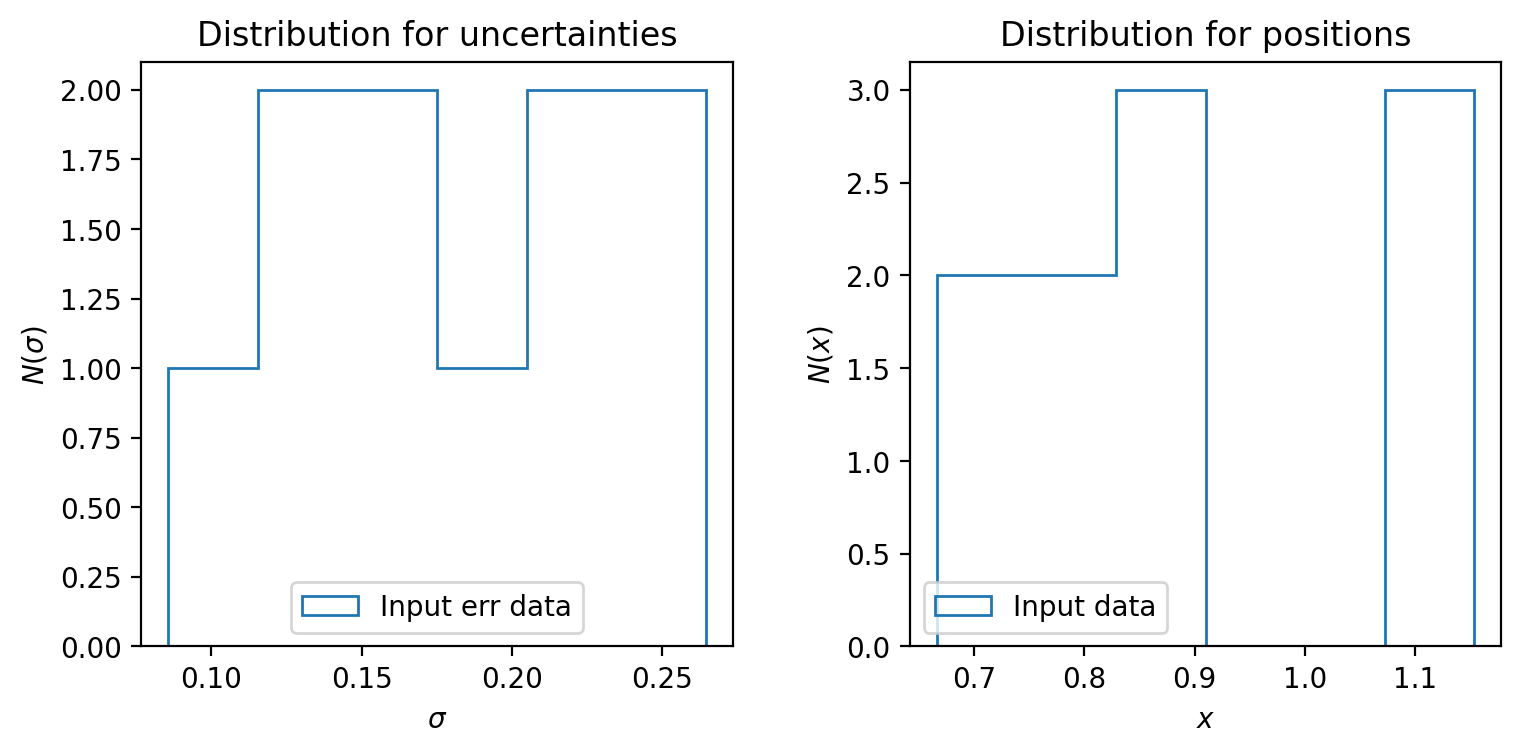

In [19]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=0.3,hspace=0.3, left=0.1, right=0.95,bottom=0.08, top=0.92)

# plot histograms
ax = fig.add_subplot(221)

#check that they do are normally distributed arround sigma with sigma_err
ax.hist(sigma_norm, bins=6, histtype='step', label="Input err data")
ax.set_title("Distribution for uncertainties")
ax.set_xlabel("$\sigma$")
ax.set_ylabel("$N(\sigma)$")
ax.legend()
#ax.set_xlim(0,2)
#ax.set_ylim(-0.5,2.5)


ax = fig.add_subplot(222)

ax.hist(x_norm_hetero, bins=6, histtype='step', label="Input data")
ax.set_title("Distribution for positions")
ax.set_xlabel("$x$")
ax.set_ylabel("$N(x)$")
ax.legend()
#ax.set_xlim(0,2)
#ax.set_ylim(-1,10)

plt.show()

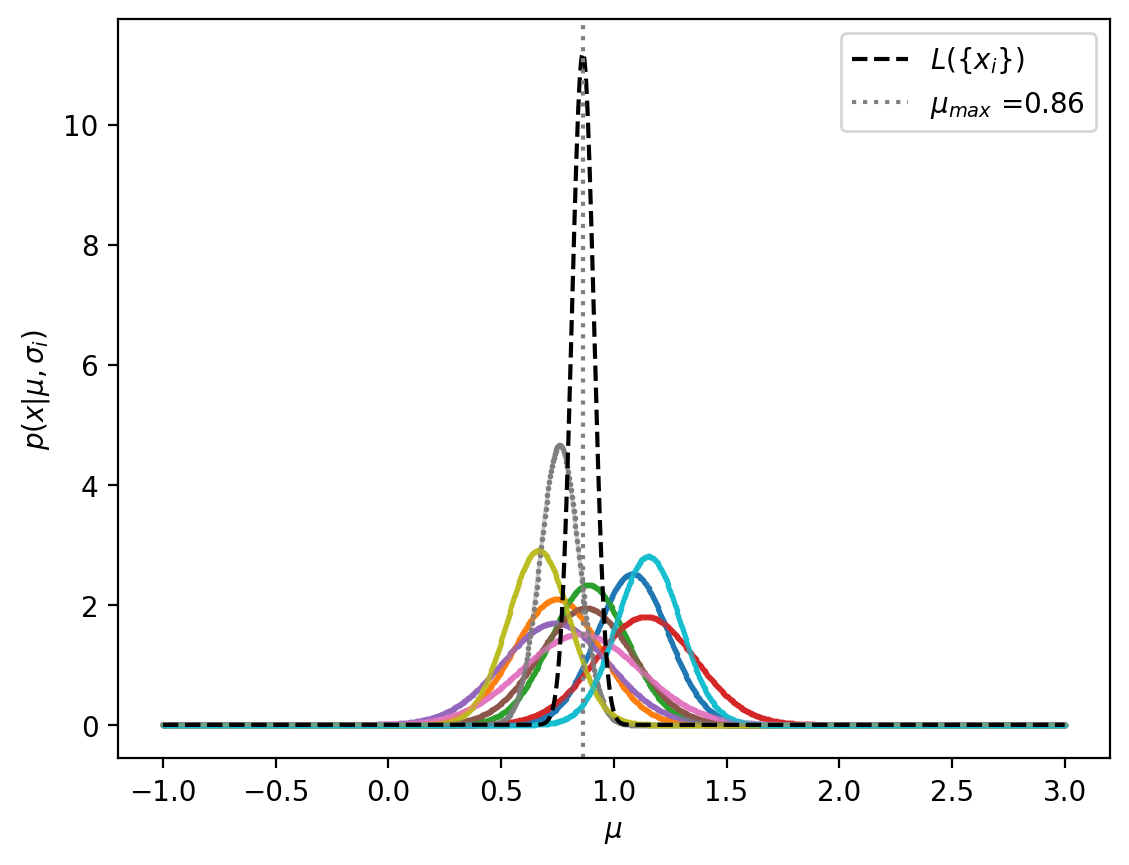

In [20]:
x_data_hetero = np.zeros((N,n))
y_data_hetero = np.zeros((N,n))
y_tot_hetero = []

for i in range(0,N):
    y_i = stats.norm.pdf(x_gaus_hetero, x_norm_hetero[i], sigma_norm[i])
    y_data_hetero[i,:] = y_i
    plt.scatter(x_gaus_hetero, y_data_hetero[i,:], s=1)
    plt.plot(x_gaus_hetero, y_data_hetero[i,:],alpha=0.4)
    #plt.axvline(x = x_norm[i], color='gray', ls='dashed', zorder=0)
    
y_tot_hetero = np.array([np.prod(y_data_hetero[:,i]) for i in np.arange(0,n)])
MLE_hetero = np.argmax(y_tot_hetero)
y_sum_log_hetero = [np.sum(np.log(y_data_hetero[:,i])) for i in np.arange(0,n)]
#print(len(y_sum_log_hetero),len(y_tot_hetero))    

plt.plot(x_gaus_hetero, y_tot_hetero, '--k', label='$L(\{x_i\})$')
plt.axvline(x = x_gaus_hetero[MLE_hetero], c='gray', ls='dotted', label='$\mu_{max}$ =' f'{round(x_gaus_hetero[MLE_hetero],2)}')

plt.xlabel('$\mu$')
plt.ylabel('$p(x|\mu,\sigma_i)$')
plt.legend()
plt.show()

In [21]:
mean_hetero = np.average(x_norm_hetero,weights=1/(sigma_norm)**2)
s_mean_hetero = (np.sum(1/(sigma_norm)**2))**(-0.5)
mu_loglike_hetero = x_gaus_hetero[MLE_hetero]
print(mean_hetero, mu_loglike_hetero, s_mean_hetero)

0.862738839047849 0.8618618618618619 0.04896660383891394


The uncertainties on $\mu$ are then computed as:

In [22]:
diff_y_n2 = np.diff(y_sum_log_hetero, n=2)
diff_x_n1 = np.diff(x_gaus_hetero, n=1)
y_second_order = diff_y_n2/(diff_x_n1[:-1])**2
F = np.mean(y_second_order)
sigma_mu_hetero = 1/np.sqrt(-F)
print(sigma_mu_hetero, s_mean_hetero)

0.04896660383891443 0.04896660383891394


In [23]:
print("Differences between means (order of 10 to the):", round(np.log10(np.abs(mu_loglike_hetero-mean_hetero))), 
      "\nDifferences between sigmas (order of 10 to the):", round(np.log10(np.abs(sigma_mu_hetero-s_mean_hetero))))

Differences between means (order of 10 to the): -3 
Differences between sigmas (order of 10 to the): -15
